# TensorFlow Batch Normalization

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Prepare some data for training

In [4]:
x_data = np.linspace(-1, 1, 5000)
noises = np.random.random((5000,))*0.1
y_data = x_data * x_data + noises

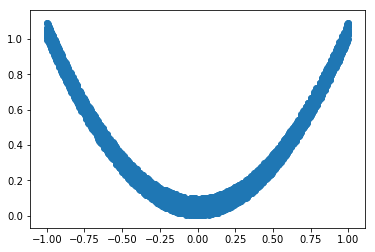

In [5]:
plt.scatter(x_data, y_data)
plt.show()

Batch the data

In [6]:
def get_batch(batch_size=32):
    global x_data, y_data
    batch_item_index = random.sample(range(1, 5000), batch_size)
    x_batch = x_data[batch_item_index][:,np.newaxis]
    y_batch = y_data[batch_item_index][:,np.newaxis]
    return x_batch, y_batch

## Build network without batch normalization

Network Parameters

In [8]:
activation = tf.nn.sigmoid
n_input_size = 1
n_hidden_layers = 7
n_hidden_units = 30
n_output_size = 1

Placeholders

In [9]:
xs = tf.placeholder(shape=[None, n_input_size],  dtype=tf.float32, name='input')
ys = tf.placeholder(shape=[None, n_output_size], dtype=tf.float32, name='output')

Add Layer Function

In [10]:
def add_layer(inputs, in_size, out_size, activation_function=None, use_bn=False):
    Weights = tf.Variable(tf.random_normal([in_size, out_size], mean=0., stddev=1.))
    biases = tf.Variable(tf.zeros([1, out_size]) + 0.1)
    Wx_plus_b = tf.matmul(inputs, Weights) + biases
    if activation_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activation_function(Wx_plus_b)
    return outputs

Build Network without Batch Normalization
- Save input of each layer in a list where we will use for vis later

In [11]:
# Input Layer: xs
layer_inputs = [xs]

# Add 7 Hidden Layers with 30 Hidden Units
for i in range(n_hidden_layers):
    inputs = layer_inputs[i]
    if i==0:
        h_layer = add_layer(inputs, n_input_size,   n_hidden_units, activation, use_bn=False)
    else:
        h_layer = add_layer(inputs, n_hidden_units, n_hidden_units, activation, use_bn=False)
    layer_inputs.append(h_layer)

# Output Layer
predictions = tf.layers.dense(inputs=h_layer, units=1, activation=activation)

Train and Loss

In [12]:
loss = tf.losses.absolute_difference(labels=ys, predictions=predictions)
train = tf.train.AdamOptimizer(0.0001).minimize(loss)

## Start Training

In [13]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())

for i in range(1000):
    x_input, y_input = get_batch()
    sess.run(train, feed_dict={
        xs: x_input,
        ys: y_input
    })
    
inputs = sess.run(layer_inputs, feed_dict={
    xs: x_data[:,np.newaxis],
    ys: y_data[:,np.newaxis]
})

## Show how the inputs distributions changes in each layer

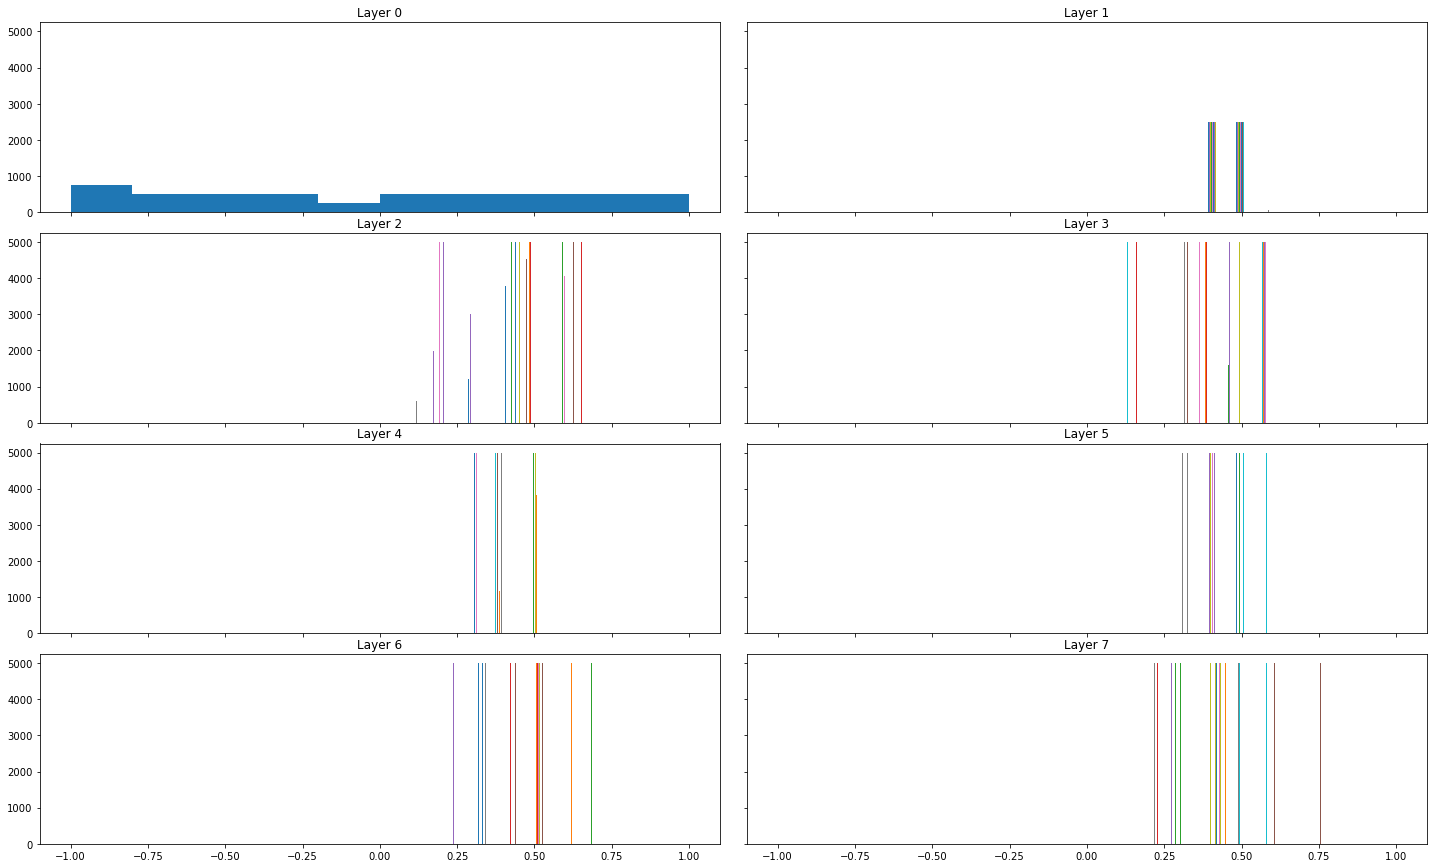

In [18]:
f, (axes_1, axes_2, axes_3, axes_4) = plt.subplots(4, 2, sharex=True, sharey=True) 

f.set_figwidth(20)
f.set_figheight(12)
f.tight_layout()

for i, ax in enumerate(list(axes_1)+list(axes_2)+list(axes_3)+list(axes_4)):
    ax.hist(inputs[i])
    ax.set_title('Layer '+str(i))

plt.show()

---

## Build Network with Batch Normalization

In [15]:
# Input Layer: xs
layer_inputs = [xs]

# Add 7 Hidden Layers with 30 Hidden Units
for i in range(n_hidden_layers):
    h_layer = tf.layers.dense(inputs=layer_inputs[i], units=n_hidden_units)
    h_layer_bn = tf.layers.batch_normalization(inputs=h_layer)
    h_layer_bn_ac = activation(h_layer_bn)
    layer_inputs.append(h_layer_bn_ac)

# Output Layer
predictions = tf.layers.dense(inputs=h_layer_bn_ac, units=1, activation=activation)

## Start Training

In [16]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())

for i in range(1000):
    x_input, y_input = get_batch()
    sess.run(train, feed_dict={
        xs: x_input,
        ys: y_input
    })
    
inputs = sess.run(layer_inputs, feed_dict={
    xs: x_data[:,np.newaxis],
    ys: y_data[:,np.newaxis]
})

## Show how the inputs distributions changes in each layer

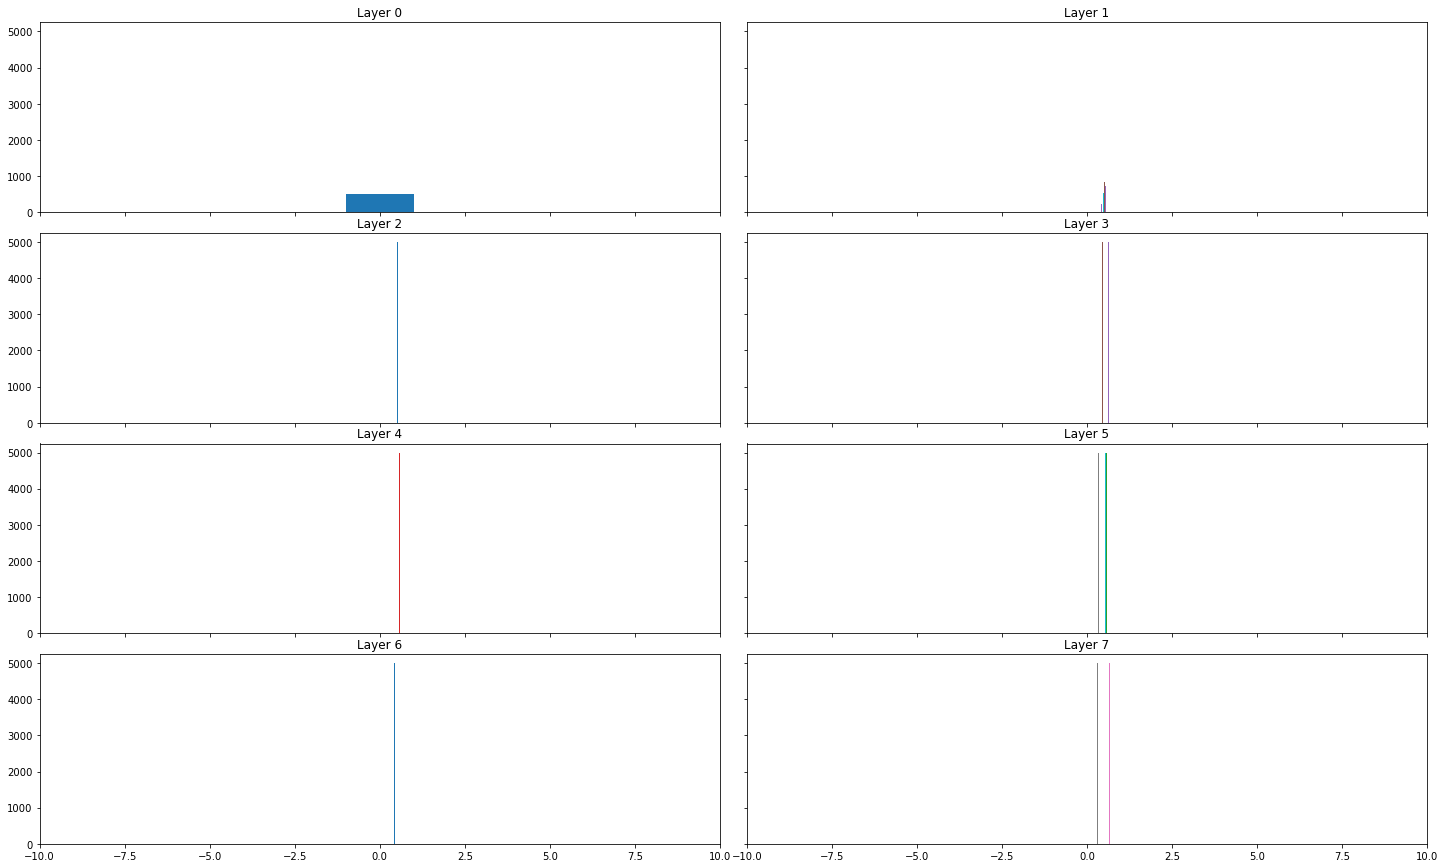

In [17]:
f, (axes_1, axes_2, axes_3, axes_4) = plt.subplots(4, 2, sharex=True, sharey=True) 

f.set_figwidth(20)
f.set_figheight(12)
f.tight_layout()

for i, ax in enumerate(list(axes_1)+list(axes_2)+list(axes_3)+list(axes_4)):
    ax.hist(inputs[i])
    ax.set_xlim((-10, 10))
    ax.set_title('Layer '+str(i))

plt.show()

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11


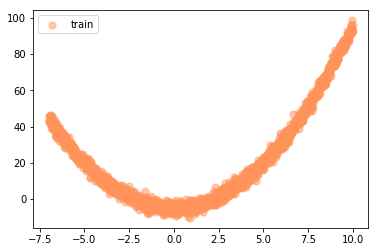

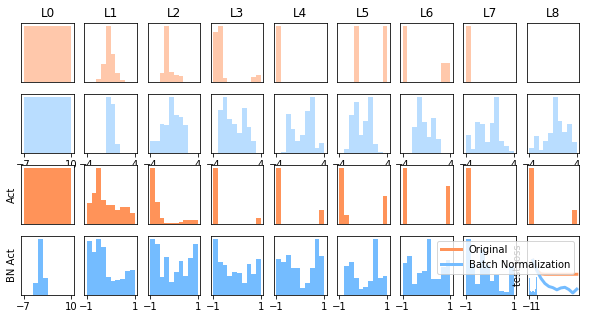

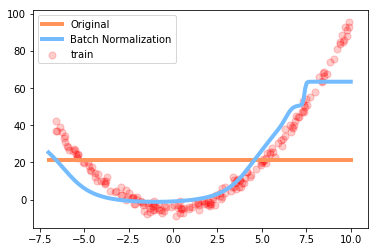

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.set_random_seed(1)
np.random.seed(1)

# Hyper parameters
N_SAMPLES = 2000
BATCH_SIZE = 64
EPOCH = 12
LR = 0.03
N_HIDDEN = 8
ACTIVATION = tf.nn.tanh
B_INIT = tf.constant_initializer(-0.2)      # use a bad bias initialization

# training data
x = np.linspace(-7, 10, N_SAMPLES)[:, np.newaxis]
np.random.shuffle(x)
noise = np.random.normal(0, 2, x.shape)
y = np.square(x) - 5 + noise
train_data = np.hstack((x, y))

# test data
test_x = np.linspace(-7, 10, 200)[:, np.newaxis]
noise = np.random.normal(0, 2, test_x.shape)
test_y = np.square(test_x) - 5 + noise

# plot input data
plt.scatter(x, y, c='#FF9359', s=50, alpha=0.5, label='train')
plt.legend(loc='upper left')

# tensorflow placeholder
tf_x = tf.placeholder(tf.float32, [None, 1])
tf_y = tf.placeholder(tf.float32, [None, 1])
tf_is_train = tf.placeholder(tf.bool, None)     # flag for using BN on training or testing


class NN(object):
    def __init__(self, batch_normalization=False):
        self.is_bn = batch_normalization

        self.w_init = tf.random_normal_initializer(0., .1)  # weights initialization
        self.pre_activation = [tf_x]
        if self.is_bn:
            self.layer_input = [tf.layers.batch_normalization(tf_x, training=tf_is_train)]  # for input data
        else:
            self.layer_input = [tf_x]
        for i in range(N_HIDDEN):  # adding hidden layers
            self.layer_input.append(self.add_layer(self.layer_input[-1], 10, ac=ACTIVATION))
        self.out = tf.layers.dense(self.layer_input[-1], 1, kernel_initializer=self.w_init, bias_initializer=B_INIT)
        self.loss = tf.losses.mean_squared_error(tf_y, self.out)

        # !! IMPORTANT !! the moving_mean and moving_variance need to be updated,
        # pass the update_ops with control_dependencies to the train_op
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            self.train = tf.train.AdamOptimizer(LR).minimize(self.loss)

    def add_layer(self, x, out_size, ac=None):
        x = tf.layers.dense(x, out_size, kernel_initializer=self.w_init, bias_initializer=B_INIT)
        self.pre_activation.append(x)
        # the momentum plays important rule. the default 0.99 is too high in this case!
        if self.is_bn: x = tf.layers.batch_normalization(x, momentum=0.4, training=tf_is_train)    # when have BN
        out = x if ac is None else ac(x)
        return out

nets = [NN(batch_normalization=False), NN(batch_normalization=True)]    # two nets, with and without BN

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# plot layer input distribution
f, axs = plt.subplots(4, N_HIDDEN+1, figsize=(10, 5))
plt.ion()   # something about plotting

def plot_histogram(l_in, l_in_bn, pre_ac, pre_ac_bn):
    for i, (ax_pa, ax_pa_bn, ax,  ax_bn) in enumerate(zip(axs[0, :], axs[1, :], axs[2, :], axs[3, :])):
        [a.clear() for a in [ax_pa, ax_pa_bn, ax, ax_bn]]
        if i == 0: p_range = (-7, 10); the_range = (-7, 10)
        else: p_range = (-4, 4); the_range = (-1, 1)
        ax_pa.set_title('L' + str(i))
        ax_pa.hist(pre_ac[i].ravel(), bins=10, range=p_range, color='#FF9359', alpha=0.5)
        ax_pa_bn.hist(pre_ac_bn[i].ravel(), bins=10, range=p_range, color='#74BCFF', alpha=0.5)
        ax.hist(l_in[i].ravel(), bins=10, range=the_range, color='#FF9359')
        ax_bn.hist(l_in_bn[i].ravel(), bins=10, range=the_range, color='#74BCFF')
        for a in [ax_pa, ax, ax_pa_bn, ax_bn]:
            a.set_yticks(()); a.set_xticks(())
        ax_pa_bn.set_xticks(p_range); ax_bn.set_xticks(the_range); axs[2, 0].set_ylabel('Act'); axs[3, 0].set_ylabel('BN Act')
    plt.pause(0.01)

losses = [[], []]   # record test loss
for epoch in range(EPOCH):
    print('Epoch: ', epoch)
    np.random.shuffle(train_data)
    step = 0
    in_epoch = True
    while in_epoch:
        b_s, b_f = (step*BATCH_SIZE) % len(train_data), ((step+1)*BATCH_SIZE) % len(train_data) # batch index
        step += 1
        if b_f < b_s:
            b_f = len(train_data)
            in_epoch = False
        b_x, b_y = train_data[b_s: b_f, 0:1], train_data[b_s: b_f, 1:2]         # batch training data
        sess.run([nets[0].train, nets[1].train], {tf_x: b_x, tf_y: b_y, tf_is_train: True})     # train

        if step == 1:
            l0, l1, l_in, l_in_bn, pa, pa_bn = sess.run(
                [nets[0].loss, nets[1].loss, nets[0].layer_input, nets[1].layer_input,
                 nets[0].pre_activation, nets[1].pre_activation],
                {tf_x: test_x, tf_y: test_y, tf_is_train: False})
            [loss.append(l) for loss, l in zip(losses, [l0, l1])]   # recode test loss
            plot_histogram(l_in, l_in_bn, pa, pa_bn)     # plot histogram

plt.ioff()

# plot test loss
plt.figure(2)
plt.plot(losses[0], c='#FF9359', lw=3, label='Original')
plt.plot(losses[1], c='#74BCFF', lw=3, label='Batch Normalization')
plt.ylabel('test loss'); plt.ylim((0, 2000)); plt.legend(loc='best')

# plot prediction line
pred, pred_bn = sess.run([nets[0].out, nets[1].out], {tf_x: test_x, tf_is_train: False})
plt.figure(3)
plt.plot(test_x, pred, c='#FF9359', lw=4, label='Original')
plt.plot(test_x, pred_bn, c='#74BCFF', lw=4, label='Batch Normalization')
plt.scatter(x[:200], y[:200], c='r', s=50, alpha=0.2, label='train')
plt.legend(loc='best'); plt.show()